In [5]:
pip install music21

Note: you may need to restart the kernel to use updated packages.


In [21]:
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from datetime import datetime

In [22]:
music_folder = 'C_midi_songs'

""" Get all the notes and chords from the midi files in the ./midi_songs directory """
notes = []

for file in glob.glob(music_folder + "/*.mid"): # midi_songs/*.mid
    
    print("Parsing %s" % file)
    
    midi = converter.parse(file)

    notes_to_parse = None

    try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse()
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

with open('data/notes_midi', 'wb') as filepath:
    pickle.dump(notes, filepath)

Parsing C_midi_songs/Fierce_Battle_(Piano).mid
Parsing C_midi_songs/ff4pclov.mid
Parsing C_midi_songs/FF6epitaph_piano.mid
Parsing C_midi_songs/fortresscondor.mid
Parsing C_midi_songs/FFX_-_Ending_Theme_(Piano_Version)_-_by_Angel_FF.mid
Parsing C_midi_songs/Fyw_piano.mid
Parsing C_midi_songs/Finalfantasy6fanfarecomplete.mid
Parsing C_midi_songs/ff1battp.mid
Parsing C_midi_songs/Kingdom_Hearts_Traverse_Town.mid
Parsing C_midi_songs/costadsol.mid
Parsing C_midi_songs/Ff4-BattleLust.mid
Parsing C_midi_songs/Still_Alive-1.mid
Parsing C_midi_songs/dayafter.mid
Parsing C_midi_songs/ViviinAlexandria.mid
Parsing C_midi_songs/Cids.mid
Parsing C_midi_songs/figaro.mid
Parsing C_midi_songs/Finalfantasy5gilgameshp.mid
Parsing C_midi_songs/tpirtsd-piano.mid
Parsing C_midi_songs/ff7themep.mid
Parsing C_midi_songs/Ff7-One_Winged.mid
Parsing C_midi_songs/relmstheme-piano.mid
Parsing C_midi_songs/decisive.mid
Parsing C_midi_songs/Final_Fantasy_Matouyas_Cave_Piano.mid
Parsing C_midi_songs/ultros.mid
Pars

In [26]:
weights_folder = 'weights_folder/'
EPOCHS = 100
GPUs = 8
BATCH_SIZE = 4096

""" This module prepares midi file data and feeds it to the neural
    network for training.
    Code from https://github.com/Skuldur/Classical-Piano-Composer/ with small changes """

def prepare_sequences(notes, n_vocab, sequence_length):
    """ Prepare the sequences used by the Neural Network """

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return network_input, normalized_input, network_output

def create_network(normalized_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        300,
        input_shape=(normalized_input.shape[1], normalized_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(300))
    model.add(Dense(150))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

def train(parallel_model, network_input, network_output):
    """ train the neural network """
    filepath = weights_folder + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    return parallel_model.fit(network_input, network_output, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)

def make_figure(X, graph_title, x_label, y_label, picture_name):
    fig = plt.figure()
    plt.plot(X)
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    fig.savefig(picture_name + '.png', dpi=100)
    plt.show()

def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        print(note_index)
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

In [28]:
#PREPARE INPUT AND CREATE MODEL
with open('data/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

SEQUENCE_LENGTH = 100

# get amount of pitch names
n_vocab = len(set(notes))

# get all pitch names
pitchnames = sorted(set(item for item in notes))

network_input, normalized_input, network_output = prepare_sequences(notes, n_vocab, SEQUENCE_LENGTH)

model = create_network(normalized_input, n_vocab)

ValueError: Initializer for variable lstm_29/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

In [24]:
#TRAIN MODEL

parallel_model = multi_gpu_model(model, gpus=GPUs)
parallel_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

train_history = train(parallel_model, normalized_input, network_output)

ValueError: Operation 'IsVariableInitialized_112' has been marked as not fetchable.

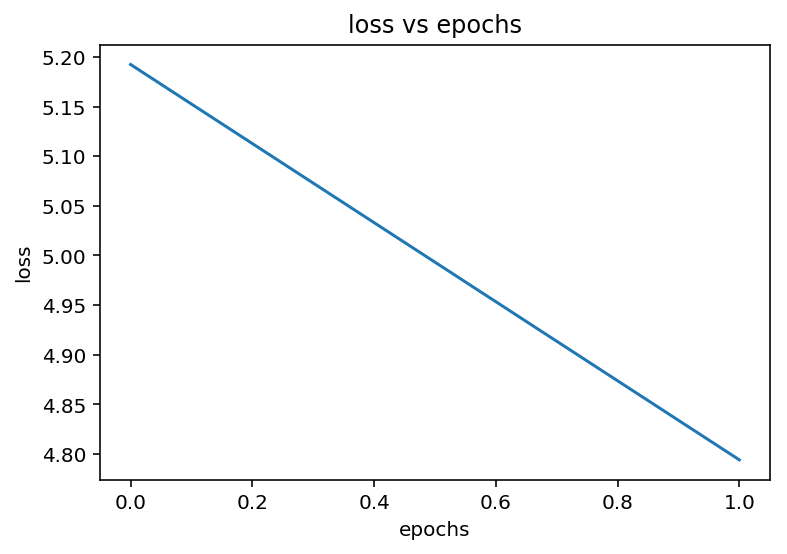

In [26]:
#GRAPH LOSS FROM TRAINING
    
loss = train_history.history['loss']
make_figure(loss, 'loss vs epochs', 'epochs', 'loss', 'train1')

In [22]:
#GENERATE NOTES FROM WEIGHTS FROM TRAINING
weights_folder = 'Seq_size_150_1/'

parallel_model.load_weights(weights_folder + 'weights.hdf5')
prediction_output = generate_notes(parallel_model, network_input, pitchnames, n_vocab)
create_midi(prediction_output)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

weights_folder = 'Seq_size_50_'
sequence_lengths = [150]

def train_cross_val(parallel_model, X_t, X_val, y_t, y_val, seq_len, k):
    """ train the neural network """
    filepath = 'Seq_size_' + str(seq_len) + '_' + str(k) + "/weights-improvement-{epoch:02d}-{val_loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    return parallel_model.fit(X_t, y_t, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                              validation_data=(X_val, y_val), callbacks=callbacks_list)

def make_figure_cross_val(t_loss, val_loss, graph_title, x_label, y_label, picture_name):
    fig = plt.figure()
    plt.plot(t_loss, color='blue', label='train')
    plt.plot(val_loss, color='red', label='validation')
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper right')
    fig.savefig(picture_name + '.png', dpi=100)
    plt.show()

def cross_val(k_folds, seq_len):
    X_train, X_test, y_train, y_test = train_test_split(normalized_input, network_output, 
                                                    test_size=0.25, shuffle=True) ##CHANGE TEST SIZE!!!!
    
    k = 0
    test_loss = [0] * k_folds
    kf = KFold(n_splits=k_folds)
    for train_index, test_index in kf.split(X_train):
        X_t, X_val = X_train[train_index], X_train[test_index]
        y_t, y_val = y_train[train_index], y_train[test_index]
        
        print(len(X_train))
        
        model = create_network(normalized_input, n_vocab)
        parallel_model = multi_gpu_model(model, gpus=GPUs)
        print('optimizer')
        optimizer = RMSprop(lr=0.05)
        print()
        parallel_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        
        print(n_vocab)
        print('TRAINING')
        train_history = train_cross_val(parallel_model, X_t, X_val, y_t, y_val, seq_len, k)

        #GRAPH LOSS FROM TRAINING

        loss_t = train_history.history['loss']
        val_loss = train_history.history['val_loss']
        make_figure_cross_val(loss_t, val_loss, 
                              'Sequence Length ' + str(seq_len) + ', k = '+ str(k), 
                              'epochs', 'loss', 'train' + str(seq_len) + '_' + str(k))
    
#         print(datetime.now().time())
#         test_loss[k] = parallel_model.evaluate(X_test, y_test, verbose=False)
#         print(datetime.now().time())

        k += 1

#     make_figure(test_loss, 'Test loss for cross validated sets, Seq_len = ' + str(seq_len),
#                 'k', 'loss', 'test' + str(seq_len))

for seq_len in sequence_lengths:
    network_input, normalized_input, network_output = prepare_sequences(notes, n_vocab, seq_len)

    cross_val(3, seq_len)

    

39790


ValueError: Initializer for variable lstm_23/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.